## Imports

In [75]:
import re
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## Utils

In [76]:
def parse_performance_data(text):
    pattern = re.compile(
        r"Algorithm:\s*(?P<Algorithm>\S+)\s*"
        r"Instance:\s*(?P<Instance>\S+)\s*"
        r"Initial Score:\s*(?P<Initial_Score>\d+)\s*"
        r"Score:\s*(?P<Score>\d+)\s*"
        r"Number\s*of\s*Evaluations:\s*(?P<Number_of_Evaluations>\d+)\s*"
        r"Number\s*of\s*Performed\s*Moves:\s*(?P<Number_of_Performed_Moves>\d+)\s*"
        r"Number\s*of\s*Best\s*Solution\s*Updates:\s*(?P<Number_of_Best_Solution_Updates>\d+)\s*"
        r"Solution:\s*(?P<Solution>[\d\s]+)\s*"
        r"Optimal\s*Score:\s*(?P<Optimal_Score>\d+)\s*"
        r"Optimal\s*Solution:\s*(?P<Optimal_Solution>[\d\s]+)"
    )
    
    rows = []
    for match in pattern.finditer(text):
        row = match.groupdict()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    numerical_cols = ['Initial_Score', 'Score', 'Number_of_Evaluations', 'Number_of_Performed_Moves', 'Number_of_Best_Solution_Updates', 'Optimal_Score']
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)
    
    return df

def parse_runtime_data(text):
    pattern = re.compile(
        r"Algorithm:\s*(?P<Algorithm>\S+)\s*"
        r"Instance:\s*(?P<Instance>\S+)\s*"
        r"Runtime:\s*(?P<Runtime>\S+)\s*"
    )
    
    rows = []
    for match in pattern.finditer(text):
        row = match.groupdict()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    numerical_cols = ['Runtime']
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)
    
    return df

## Read Data

In [77]:
with open('results/performance_results.txt', 'r') as file:
    data = file.read()

df_performance = parse_performance_data(data)

In [78]:
df_performance.tail()

,Algorithm,Instance,Initial_Score,Score,Number_of_Evaluations,Number_of_Performed_Moves,Number_of_Best_Solution_Updates,Solution,Optimal_Score,Optimal_Solution
4795,rsteepestLS,bur26h,7747823,7098905,7150,21,21,21 2 15 11 5 7 9 14 0 20 19 6 3 17 13 24 18 8 ...,7098658,11 2 13 12 6 10 25 8 1 21 4 20 7 18 14 15 9 19...
4796,rsteepestLS,bur26h,8276596,7123039,8775,26,26,5 12 1 15 11 24 0 9 2 14 18 17 19 3 10 20 4 8 ...,7098658,11 2 13 12 6 10 25 8 1 21 4 20 7 18 14 15 9 19...
4797,rsteepestLS,bur26h,7995157,7153247,7800,23,23,1 23 7 5 6 12 25 13 2 10 8 4 18 0 14 15 19 17 ...,7098658,11 2 13 12 6 10 25 8 1 21 4 20 7 18 14 15 9 19...
4798,rsteepestLS,bur26h,7732397,7099512,6500,19,19,22 10 1 12 5 23 16 14 0 20 19 3 6 17 11 9 18 8...,7098658,11 2 13 12 6 10 25 8 1 21 4 20 7 18 14 15 9 19...
4799,rsteepestLS,bur26h,7763367,7124989,7800,23,23,9 21 10 2 5 16 23 20 0 8 17 19 3 11 22 14 18 6...,7098658,11 2 13 12 6 10 25 8 1 21 4 20 7 18 14 15 9 19...


In [79]:
with open('results/runtime_results.txt', 'r') as file:
    data = file.read()

df_runtime = parse_runtime_data(data)

In [80]:
df_runtime.head()

,Algorithm,Instance,Runtime
0,heuristic,bur26a,6122.0
1,heuristic,bur26a,9695.0
2,heuristic,bur26a,5778.0
3,heuristic,bur26a,10452.0
4,heuristic,bur26a,5695.0


In [81]:
df_runtime[df_runtime.Algorithm == "greedyLS"].Runtime.mean()

3058801.625

# Analysis

### Problem Description
#### 8 Selected instances:

R.E. Burkard and J. Offermann [BuOf:77]
The data of the first matrix correspond to the typing-time of an average stenotypist, while the second matrix describes the frequency of pairs of letters in different languages taken over 100,000 pairs for examples a-f and over 187,778 pairs for examples g-h. (Note that the solutions are not scaled for a flow matrix of 100,000 pairs anymore.) One also distinguishes between two types of typewriter keyboards. The instances are asymmetric.

Selected due to the fact that all instances are of the same size.<br>
***Bur26a, Bur26b, Bur26c, Bur26d, Bur26e, Bur26f, Bur26g, Bur26h***

#### Neighborhood used: pair swap
#### Neighborhood size: n(n-1)/2 ? 

#### Comparison of the performance of 5 algorithms and implemented types of neighborhoods on all problem instances – plots

- Running time (average)
- Quality = distance from the optimum (according to what measure?), the average and the best case (optionally: also the worst case).
- Efficiency of algorithms (average) – i.e., quality over time (suggest a good measure and justify your choice)
- G,S: average number of algorithm steps (step = changing the current solution)
- G,S,RS,RW: average number of evaluated (i.e., visited – full or partial evaluation) solutions

For the averages, we assess the stability of the results (standard deviations should always be shown along with the averages).

In [82]:
instances = df_performance.Instance.unique()

## Runtime

In [83]:
def plot_algorithms(summary, title="Measure"):
    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    # Plot each algorithm separately
    algorithms = summary["Algorithm"].unique()
    colors = sns.color_palette("tab10", len(algorithms))

    for i, algorithm in enumerate(algorithms):
        subset = summary[summary["Algorithm"] == algorithm]
        plt.plot(subset["Instance"], subset["mean"], label=f"{algorithm} (Mean)", color=colors[i], marker="o", linestyle="-")
        plt.fill_between(subset["Instance"], subset["mean"] - subset["std"], subset["mean"] + subset["std"], alpha=0.2, color=colors[i])

    # Labels and legend
    plt.xlabel("Instance")
    plt.ylabel(title)
    plt.title(f"Algorithm {title} per Instance with Standard Deviation")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate instance labels for better readability
    plt.show()

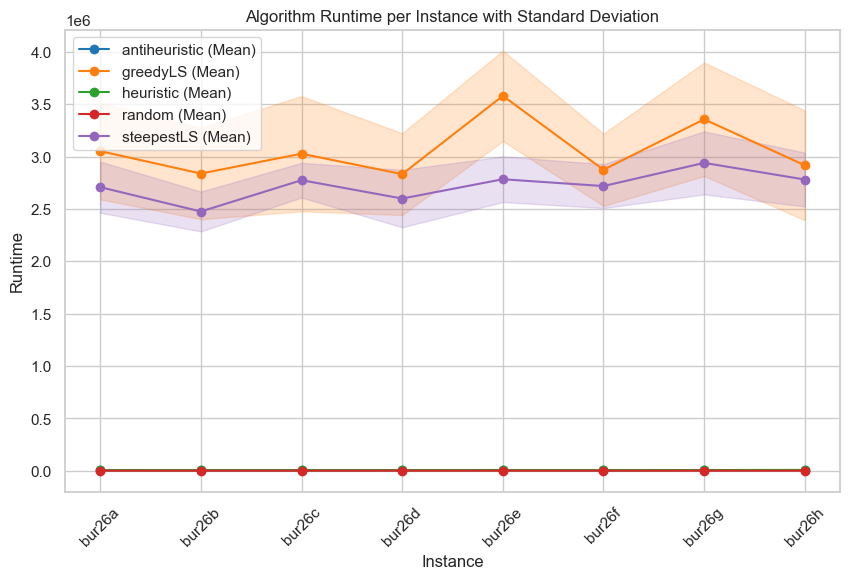

In [84]:
summary = df_runtime.groupby(["Algorithm", "Instance"])["Runtime"].agg(["mean", "std"]).reset_index()
plot_algorithms(summary, title="Runtime")

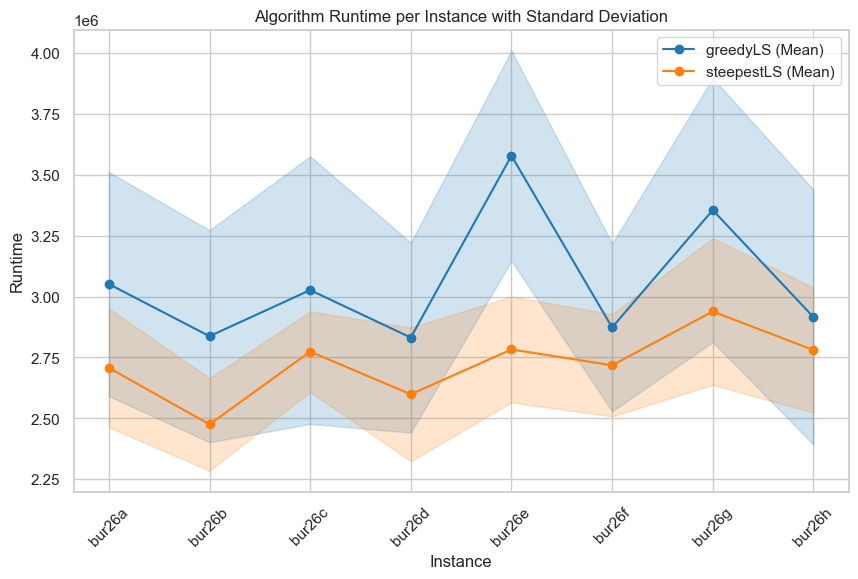

In [85]:
ls_algorithms = summary[summary["Algorithm"].str.contains("LS")]
plot_algorithms(ls_algorithms, title="Runtime")

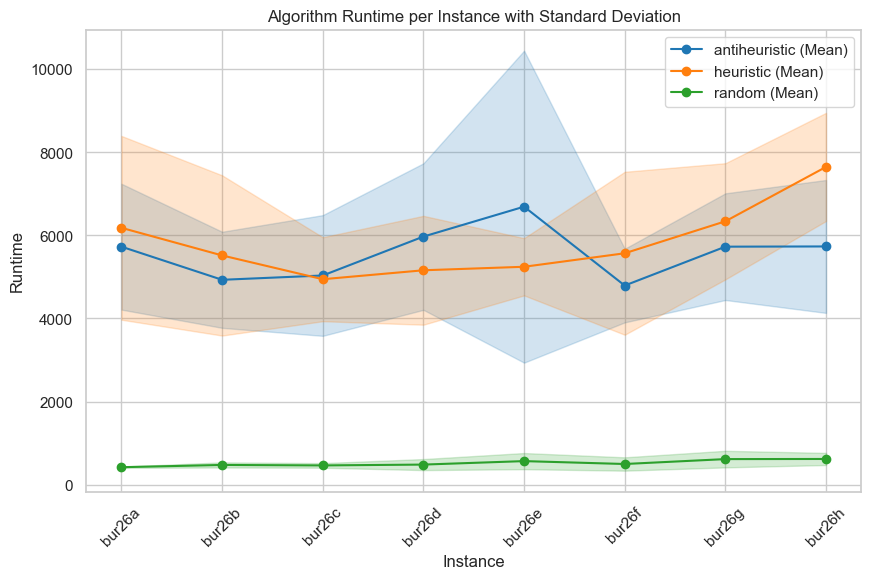

In [86]:
non_ls_algorithms = summary[~summary["Algorithm"].str.contains("LS")]
plot_algorithms(non_ls_algorithms, title="Runtime")

## Quality

In [87]:
df_performance["Solution_Quality"] = (df_performance["Score"] - df_performance["Optimal_Score"]) / df_performance["Optimal_Score"]

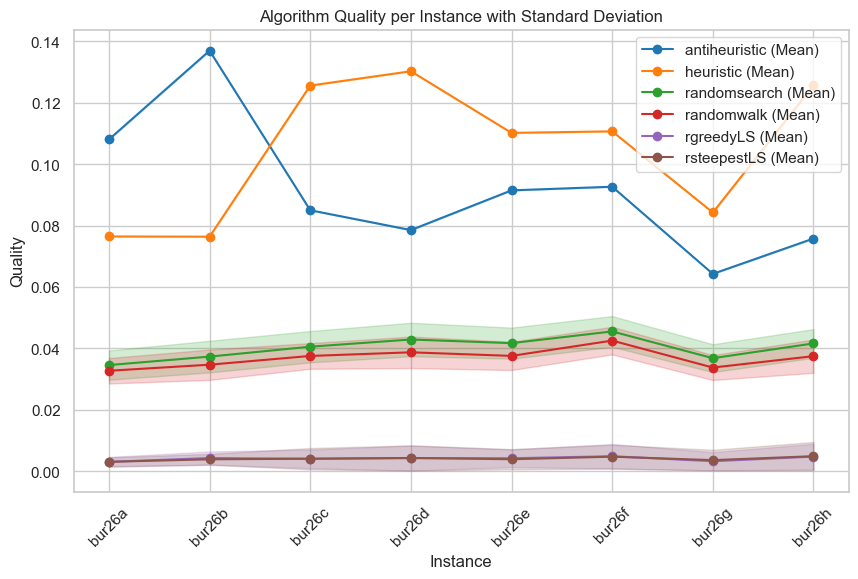

In [88]:
summary = df_performance.groupby(["Algorithm", "Instance"])["Solution_Quality"].agg(["mean", "std"]).reset_index()
plot_algorithms(summary, title="Quality")

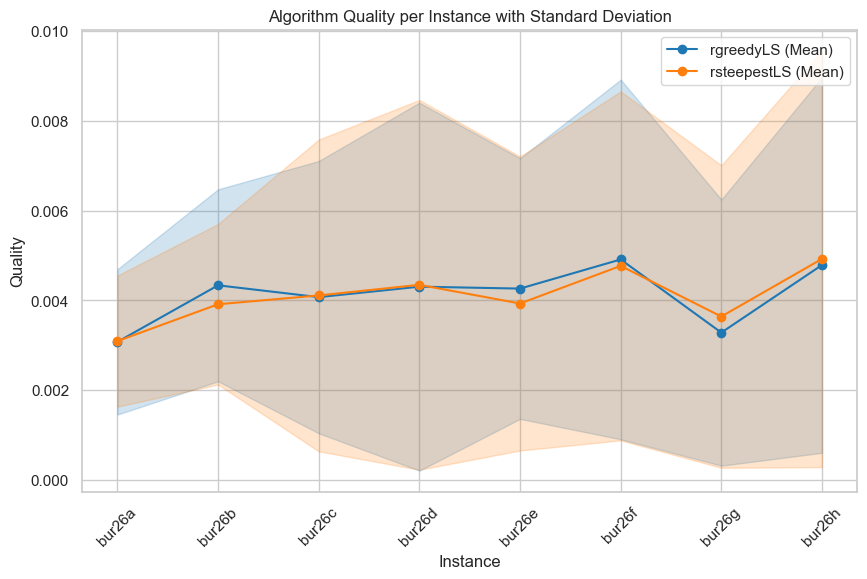

In [89]:
non_ls_algorithms = summary[summary["Algorithm"].str.contains("LS")]
plot_algorithms(non_ls_algorithms, title="Quality")

## Efficiency